## Importanto dependências

In [2]:
from matplotlib import font_manager

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import matplotlib as mpl

## Baixando datasets (Windows)

In [ ]:
!pip install -q kaggle

In [ ]:
!cp ~/Downloads/kaggle.json %HOME%/.kaggle/kaggle.json

In [ ]:
DATADIR="data"
![ ! -d "$DATADIR" ] && mkdir "$DATADIR"

!kaggle datasets download -d anokas/kuzushiji -p "$DATADIR" --unzip

## Instalando fontes e adicionando ao matplotlib (Windows)

In [ ]:
!echo %HOME%;

In [3]:
system = platform.system()

if system == 'Windows':
    font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
    font_path = os.path.join(os.path.expanduser('~'), 'AppData\Local\Microsoft\Windows\Fonts\TakaoPGothic.ttf')
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'TakaoPGothic'
    
    # Check if the font is installed
    print(font_manager.findfont("TakaoPGothic"))
# !ls C:\\Users\\medin\\anaconda3\\envs\\vision\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf
elif system == 'Linux':
    pass

C:\Users\medin\AppData\Local\Microsoft\Windows\Fonts\TakaoPGothic.ttf


## Funções auxiliares

In [4]:
# Loading classmap
class_to_hiragana = pd.read_csv('data\k49_classmap.csv').to_dict(orient='index')

def get_hiragana(key):
  return class_to_hiragana[key]['char']

def flatten(x):
    n_samples, width, height, _ = x.shape
    
    return np.reshape(x, (n_samples, width*height))

def change_theme(color):
    mpl.rcParams['axes.labelcolor'] = color
    mpl.rcParams['xtick.color'] = color
    mpl.rcParams['ytick.color'] = color
    mpl.rcParams['text.color'] = color
    
def get_classes_by_frequency(y_train):
    classes, frequencies = np.unique(y_train, return_counts=True)
    sorted_lists = sorted(zip(frequencies, classes))
    frequencies, classes = [pair for pair in zip(*sorted_lists)]
    
    hiraganas = [get_hiragana(_class) for _class in classes]
    
    return frequencies, classes, hiraganas

---
## Pré-processamento dos dados

### Carregando dados e separando conjuntos de treino e teste

In [5]:
# Loading data from compressed files
x_train = np.load('data\\k49-train-imgs.npz')['arr_0'].astype('float32')
x_test = np.load('data\\k-49-test-imgs.npz')['arr_0'].astype('float32')

# Normalize data between 0 and 1
x_train /= 255
x_test /= 255

# Adding one extra "channel" dimension
x_train_expanded = np.expand_dims(x_train, axis=-1)
x_test_expanded = np.expand_dims(x_test, axis=-1)

# Loading labels from compressed files
y_train_original = np.load('data\k49-train-labels.npz')['arr_0']
y_test_original = np.load('data\k49-test-labels.npz')['arr_0']

n_classes = len(np.unique(y_train_original))

# One hot encoding for cross entropy loss (for later when training the model)
y_train = np_utils.to_categorical(y_train_original, n_classes)
y_test = np_utils.to_categorical(y_test_original, n_classes)

In [6]:
separator = f"\n{'---' * 35}\n"
print(f'Original training data shape: {x_train.shape} -  Expanded training data shape: {x_train_expanded.shape}')
print(f'Original testing data shape: {x_test.shape}   -  Expanded testing data shape: {x_test_expanded.shape}', end=separator)

print('Number of training samples: ', x_train.shape[0])
print('Number of testing samples: ', x_test.shape[0], end=separator)

print(f'Images resolution: {x_train.shape[1]}x{x_train.shape[2]}')
print('Number of classes: ', n_classes)

Original training data shape: (232365, 28, 28) -  Expanded training data shape: (232365, 28, 28, 1)
Original testing data shape: (38547, 28, 28)   -  Expanded testing data shape: (38547, 28, 28, 1)
---------------------------------------------------------------------------------------------------------
Number of training samples:  232365
Number of testing samples:  38547
---------------------------------------------------------------------------------------------------------
Images resolution: 28x28
Number of classes:  49


### Visualizando dados

In [26]:
def visualize_random_hiraganas(x, y, n_cols=10, n_rows=5, theme_path='dark'):
  n_imgs = n_cols * n_rows
  rand_idxs = np.random.randint(x.shape[0], size=n_imgs)

  rand_samples = x[rand_idxs]
  x = [get_hiragana(y[idx]) for idx in rand_idxs]

  fig = plt.figure(figsize=(n_cols, n_rows))
  plt.subplots_adjust(top=1)

  for i in range(n_imgs):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.set_title(x[i])

    ax.tick_params(
      axis='both',
      which='both',
      labelleft=False,
      labelbottom=False,
      bottom=False,
      left=False
    )
    
    ax.imshow(rand_samples[i], cmap='gray')

  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{n_imgs}_random_samples.svg', transparent=True)
  plt.show()

def visualize_classes_unbalance(y, title=None, theme_path='dark'):
  classes, frequencies = np.unique(y, return_counts=True)
  sorted_lists = sorted(zip(frequencies, classes))
  frequencies, classes = [list(pair) for pair in zip(*sorted_lists)]

  hiraganas = [get_hiragana(class_) for class_ in classes]

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(111)
  ax1.scatter(hiraganas, frequencies)

  title = title or 'classes_unbalance'
  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{title}.svg', transparent=True)
  plt.show()

def visualize_same_class_samples(x, y, n_classes=5, n_samples=5, theme_path='dark'):
  n_rows = n_classes
  n_columns = n_samples

  np.random.seed()

  classes_range = np.unique(y) # 0 a 48
  rand_classes = np.random.randint(classes_range[0], classes_range[-1], size=n_rows)

  fig = plt.figure(figsize=(n_columns, n_rows), dpi=100)
  plt.subplots_adjust(top=1)
  
  n_imgs = n_rows + n_columns  
  i = 1
  while i <= n_imgs:
    for class_ in rand_classes:
      rand_class_idxs = np.where(y == class_)[0][:n_columns]
      for sample_idx in rand_class_idxs:
        ax = fig.add_subplot(n_rows, n_columns, i)
        ax.set_title(get_hiragana(class_))

        ax.tick_params(
          axis='both',
          which='both',
          labelleft=False,
          labelbottom=False,
          bottom=False,
          left=False
        )
        
        ax.imshow(x[sample_idx], cmap='gray')
        i += 1
      
  plt.tight_layout()
  plt.savefig(f'plots/{theme_path}/{n_rows}_classes_train_samples.svg', transparent=True)
  plt.show()

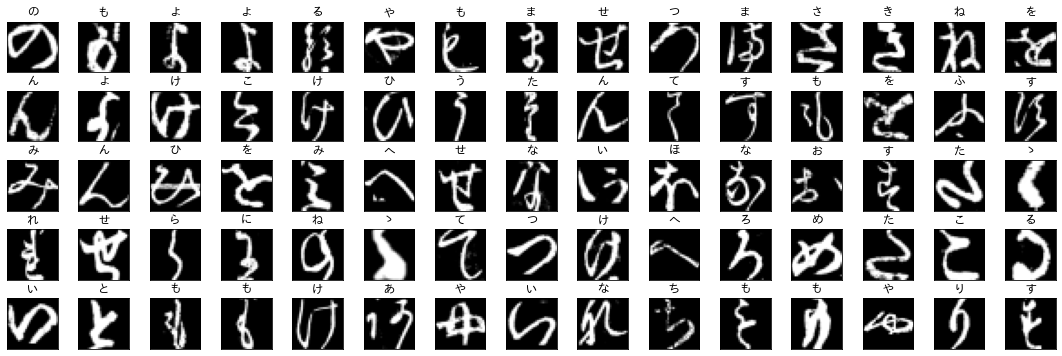

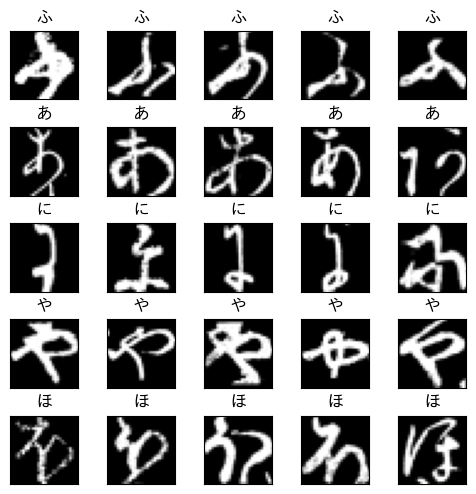

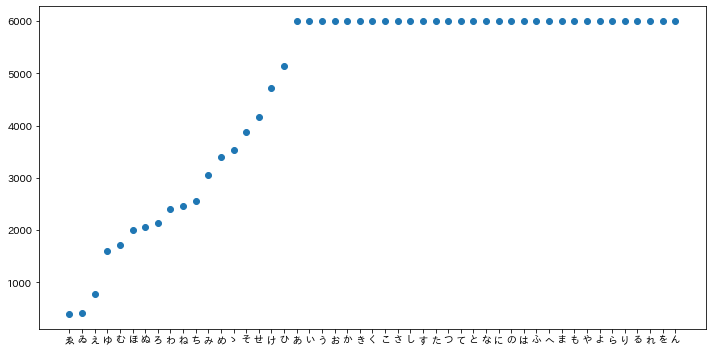

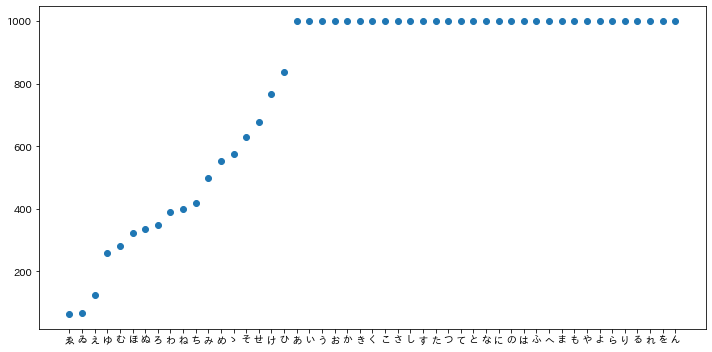

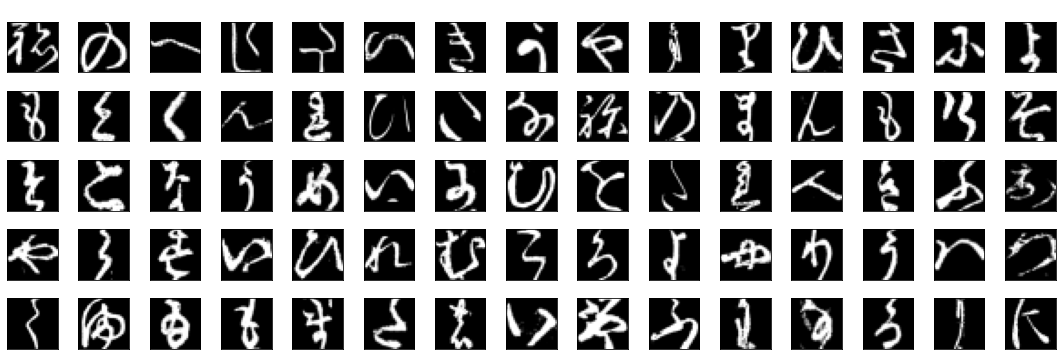

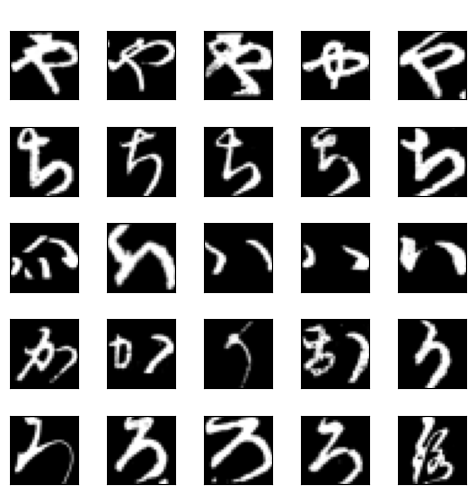

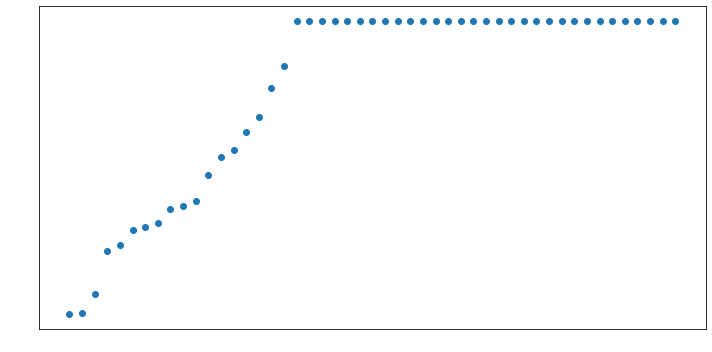

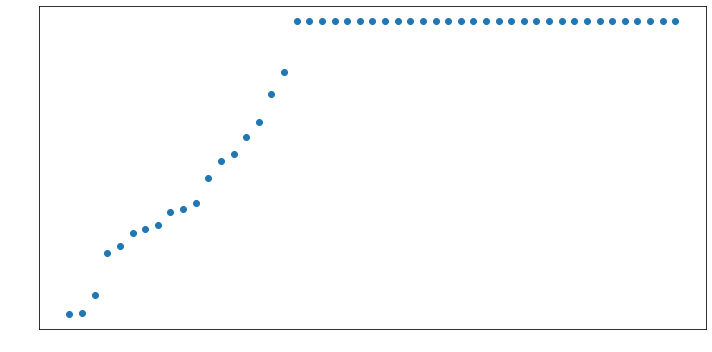

In [28]:
if not os.path.isdir('plots/dark'):
    os.makedirs('plots/dark')
if not os.path.isdir('plots/light'):
    os.makedirs('plots/light')

change_theme('black')
visualize_random_hiraganas(x_train, y_train_original, n_cols=15)
visualize_same_class_samples(x_train, y_train_original)
visualize_classes_unbalance(y_train_original, title='classes_unbalance_train_samples')
visualize_classes_unbalance(y_test_original, title='classes_unbalance_test_samples')

change_theme('white')
visualize_random_hiraganas(x_train, y_train_original, n_cols=15, theme_path='light')
visualize_same_class_samples(x_train, y_train_original, theme_path='light')
visualize_classes_unbalance(y_train_original, title='classes_unbalance_train_samples', theme_path='light')
visualize_classes_unbalance(y_test_original, title='classes_unbalance_test_samples', theme_path='light')

---
## Treinamento

### Criando modelos
A ideia é treinar vários modelos com diferentes parâmetros (número de camadas, filtros, tamanho dos filtros, otimizadores, etc) e comparar a performance, através da acurácia e da análise da curva ROC obtidas pelos modelos treinados.

Foi criada uma função **build_network_model** para gerar modelos, dados os parâmetros necessários, estes são:
- name               - nome usado nomear o arquivo h5 que irá guardar os pesos treinados de cada modelo
- network_layers     - lista de camadas sequenciais do modelo (camadas do módulo layers do keras)
- compilation_params - dict com parâmetros da compilação do modelo (otimizador, função de custo, etc)
- show_summary       - flag que faz a função imprimir uma sumarização do modelo construído

In [14]:
def build_network_model(name, network_layers, compilation_params, show_summary=False):
    model = keras.Sequential(
        network_layers,
        name
    )
    
    model.compile(**compilation_params)
    
    if show_summary:
        model.summary()
    
    return model

### Modelos
Dois tipos de modelos foram usados: redes neurais (NN) e redes neurais convolucionais (CNNs). São criadas um total de 6 redes neurais e 6 redes neurais convolucionais.<br>
As 6 redes neurais são:
- NN_1_sgd
- NN_2_sgd
- NN_1_adam
- NN_2_adam
- NN_dense
- NN_dense_batch_form

E as 6 redes neurais convolucionais são:
- CNN_1_sgd
- CNN_2_sgd
- CNN_1_adam
- CNN_2_adam
- CNN_dense
- CNN_dense_batch_form

O objetivo das 4 primeiras redes, de cada tipo de modelo, é comparar o impacto na performance que diferentes otimizadores e diferentes quantidades de camadas (para NNs) ou filtros (para CNNs) faz.<br>
As duas últimas redes de cada tipo de modelo são redes mais custosas computacionalmente, com muito mais camadas ou filtros; sendo que metade delas usa [Batch Normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) e a outra metade não. O objetivo é comparar se uma quantidade muito grande de camadas ou filtros, de fato melhora a performance consideravelmente, e se além disso, adicionar camadas de batch normalization ajuda.


In [15]:
neural_networks = [
    build_network_model(
        'NN_1_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_sgd',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_1_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_2_adam',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=64, activation='relu', name='dense_1'),
            layers.Dense(units=128, activation='relu', name='dense_2'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    ),
    build_network_model(
        'NN_dense_batch_norm',
        [
            layers.Dense(units=64, activation='relu', name='inputs', input_shape=(784,)),
            layers.Dense(units=128, activation='relu', name='dense_1'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=256, activation='relu', name='dense_2'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=512, activation='relu', name='dense_3'),
            layers.BatchNormalization(axis=1),
            layers.Dense(units=n_classes, activation='softmax', name='predictions')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']},
    )
]

conv_neural_networks = [
    build_network_model(
        'CNN_1_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_adam',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_1_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=64, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_2_sgd',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=128, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),
    build_network_model(
        'CNN_dense',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    ),    
    build_network_model(
        'CNN_dense_batch_norm',
        [
            layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(28,28,1)),
            layers.Conv2D(filters=256, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Conv2D(filters=512, kernel_size=4),
            layers.MaxPooling2D(pool_size=2),
            layers.BatchNormalization(axis=1),
            layers.Flatten(),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(units=n_classes, activation='softmax')
        ],
        {'optimizer': 'sgd', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy']}
    )
]

## Treinamento
O treinamento consiste em fazer o fit de cada modelo no conjunto de treino, separando 30% desse conjunto para validação e usando batches com 128 samples. Após o treinamento são salvos os pesos para que o treinamento não precise ser executado novamente no futuro, mas apenas carregado (vide seção [Carregando Modelos](#carregando-modelos) abaixo).

In [16]:
def train_model(model, training_params, output_path='weights'):
    model.fit(**training_params)
    
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
        
    model.save_weights(os.path.join(output_path, f'{model.name}.h5'))
    
    return model

### ATENÇÃO: só executar célula abaixo se o treinamento não tiver sido feito (basta ver se o diretório weights contém todos arquivos .h5 correspondentes aos modelos criados).

In [ ]:
x_train_flattened = flatten(x_train_expanded)

nn_trained_models = [
    train_model(
        nn_model,
        {'x': x_train_flattened, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for nn_model in neural_networks
]

cnn_trained_models = [
    train_model(
        cnn_model,
        {'x': x_train_expanded, 'y': y_train, 'batch_size': 64, 'epochs': 10, 'validation_split': 0.3}
    )
    for cnn_model in conv_neural_networks
]

---
### Carregando modelos
Se os modelos já foram treinados, basta carregar seus pesos a partir dos arquivos .h5 para avaliá-los.

In [17]:
def load_model(models, model_name):
    model = list(filter(lambda x: x.name == model_name, models))[0]
    model.load_weights(f'weights/{model_name}.h5')
    
    return model

weights_filenames = os.listdir('weights')

nn_trained_models = [load_model(neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('NN')]
cnn_trained_models = [load_model(conv_neural_networks, filename[:-3]) for filename in weights_filenames if filename.startswith('CNN')]

## Avaliação dos Modelos

### Acurácia
A avaliação dos modelos irá começar usando métricas mais simples: acurácia e loss.

In [18]:
def evaluate_model(model, x_test, y_test, should_flatten=False) -> tuple[float, float]:
    if should_flatten:
        x_test = flatten(x_test)
        
    return model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [19]:
if os.path.exists('results'):
    nn_accuracies = np.load('results/nn_accuracies.npy')
    nn_losses = np.load('results/nn_losses.npy')
    cnn_accuracies = np.load('results/cnn_accuracies.npy')
    cnn_losses = np.load('results/cnn_losses.npy')
else:
    nn_losses = []
    nn_accuracies = []
    cnn_losses = []
    cnn_accuracies = []

    for model in nn_trained_models:    
        loss, acc = evaluate_model(model, x_test_expanded, y_test, should_flatten=True)
        nn_losses.append(loss)
        nn_accuracies.append(acc)

    for model in cnn_trained_models:
        loss, acc = evaluate_model(model, x_test_expanded, y_test)
        cnn_losses.append(loss)
        cnn_accuracies.append(acc)

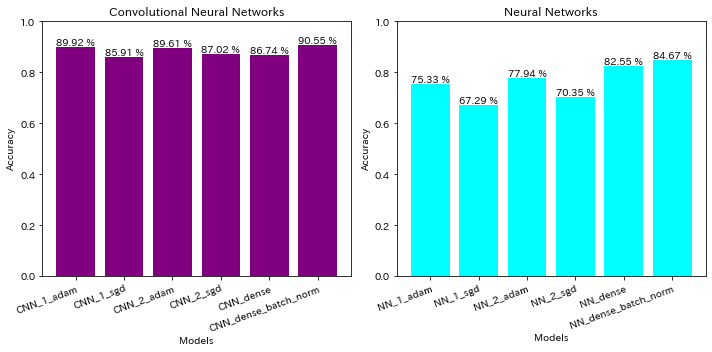

In [72]:
cnn_models_names = [trained_model.name for trained_model in cnn_trained_models]
nn_models_names = [trained_model.name for trained_model in nn_trained_models]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

subplots = [
    {'ax': axes[0], 'xtick_labels': cnn_models_names, 'data': cnn_accuracies, 'color': 'purple', 'title': 'Convolutional Neural Networks'},
    {'ax': axes[1], 'xtick_labels': nn_models_names, 'data': nn_accuracies, 'color': 'cyan', 'title': 'Neural Networks'},
]

for subplot in subplots:
    ax, xtick_labels, data, color, title = subplot.values()

    hbars = ax.bar(xtick_labels, data, color=color)

    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.set_xticks(xtick_labels)
    ax.set_xticklabels(labels=xtick_labels, rotation=20, ha='right', rotation_mode='anchor')
    ax.set(xlabel='Models', ylabel='Accuracy')

    ax.bar_label(hbars, labels=[f'{100*d:.2f} %' for d in data])

plt.tight_layout()
plt.savefig('plots/accuracies.svg', transparent=True)
plt.show()

Podemos observar que:
- Todas CNNs apresentam acurácia superior às NNs;
- Os modelos que usaram o SGD como otimizador obtiveram menor acurácia, comparados com os que usaram Adam;
- A CNN mais densa com Batch Normalization (e de longe a mais custosa computacionalmente) obteve acurácia muito semelhante a CNNs menos densas e sem Batch Normalization;
- Já a NN mais densa com Batch Normalization se saiu, levemente, melhor quando comparadas com as outras NNs;

### AUC e Curva ROC
Como mencionado anteriormente, o dataset é (propositalmente) desbalanceado, com algumas classes possuindo muito menos exemplos que outras. Portanto apenas analisar a acurária obtida pelos modelos não é suficiente para sumarizar seus desempenhos, é preciso usar métricas que levam em consideração o desbalanceio do dataset.<br>
A metodologia mais comum é, a partir da [Matriz de Confusão](https://www.youtube.com/watch?v=Kdsp6soqA7o&t=12s), extrair métricas como: precisão, recall, sensibilidade, especificidade; usadas para plotar a curva [ROC](https://www.youtube.com/watch?v=4jRBRDbJemM) de cada modelo e suas respectivas áreas sob a curva (AUC).<br>

### Curva ROC Multiclasse
Por padrão, a curva ROC é utilizada para classificadores binários, sendo um **plot por modelo**. Nesses casos, a comparação entre os modelos não apresenta problemas.<br>
Entretanto, para classificadores multiclasse (ou categóricos), é necessário utilizar uma estratégia, tal como a "one-vs-all", onde, para **um modelo**, é plotada uma curva ROC por classe, i.e., considera-se uma classe como a positiva e todas as outras como negativas. Logo, há vários plots de curva ROC por modelo, tornando difícil compará-los.<br>
Para ficar mais claro, vamos ilustrar o problema usando o dataset utilizado neste trabalho. Como o dataset Kuzushiji-49 contém 49 classes, isso significa que há 49 curvas ROC a serem plotadas para cada modelo. Execute a célula abaixo para ver o resultado:

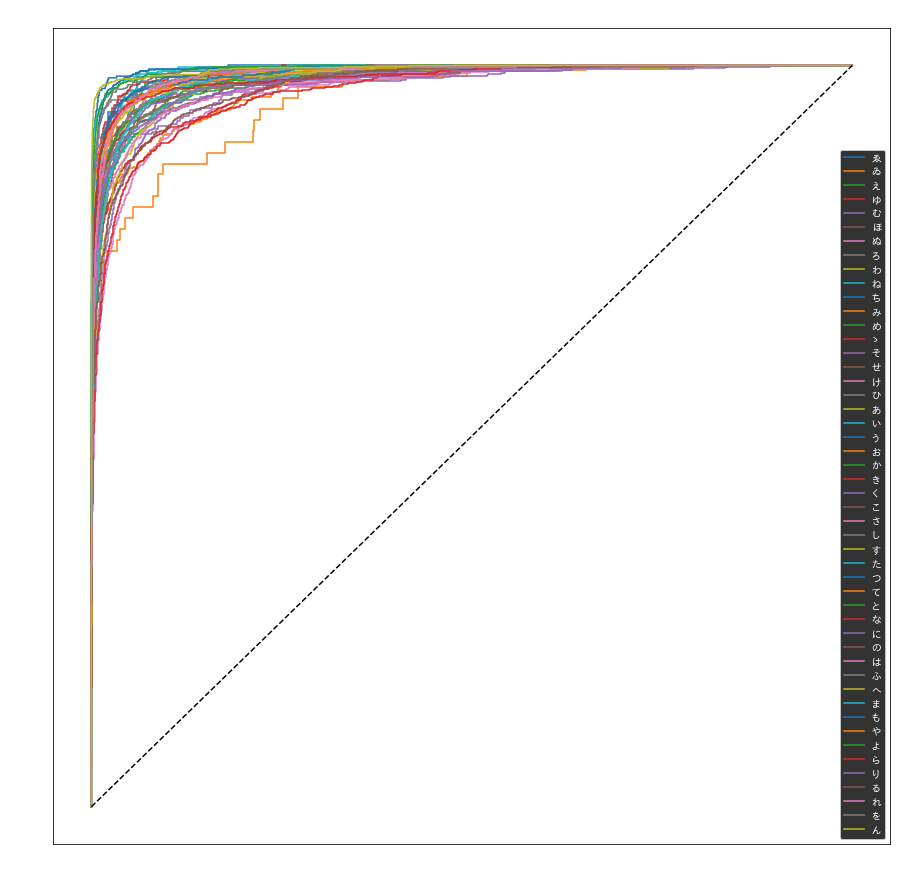

In [64]:
# def plot_roc_curve(trained_model, x_test, y_test):
trained_model = nn_trained_models[0]

x = flatten(x_test_expanded)
y = y_test
y_probs = trained_model.predict(x)

_, classes, hiraganas = get_classes_by_frequency(y_train_original)

roc_curves = [roc_curve(y[:, _class], y_probs[:, _class]) for _class in classes]

fig = plt.figure(figsize=(15, 15))

for i in range(len(roc_curves)):
    fpr, tpr, _ = roc_curves[i]
    _class = classes[i]
    plt.plot(fpr, tpr, label=get_hiragana(_class))

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20)
plt.legend(loc='best', facecolor='k', labelcolor='w')
plt.savefig('plots/ROC_nightmare.svg', transparent=True)
plt.show()

É possível notar que o modelo em questão aprendeu algumas classes melhor que outras (quanto mais "alta e para a esquerda" ela for - próxima do "céu ROC") porém é difícil tirar quaisquer conclusões devido a quantidade de classes.
Para nossa felicidade, existe uma maneira de sumarizar esses resultados, a área sob a curva - AUC.

### AUC Multiclasse
Quando lidando com classificadores binários, uma maneira de comparar a curva ROC (note que está no singular) de cada modelo é através da área sob a curva (AUC) de cada curva, pois como se trata apenas de um valor, basta verificar quem possui o maior para saber quem é o melhor.<br>
No caso de classificadores multiclasse temos, para um modelo, várias curvas ROC, e portanto um valor de AUC para cada classe (considerando a abordagem "one-vs-all").<br>
A seguir plotamos os valores de AUC para cada classe, **ordenadas pela quantidade de amostras**, fazendo a seguinte comparação entre os modelos:
- NN com otimizador Adam com maior acurácia vs NN com otimizador SGD com maior acurácia;
- CNN com otimizador Adam com maior acurácia vs CNN com otimizador SGD com maior acurácia;
- NN densa com e sem Batch Normalization;
- CNN densa com e sem Batch Normalization;
- NN com maior acurácia vs CNN com maior acurácia;

### SPOILER: a visualização desses valores em gráficos de barra é interessante, para ter uma noção geral do "desbalanceio no aprendizado de cada classe", mas não muito útil para extrair conclusões definitivas, isso será feito na próxima seção.

In [20]:
def get_auc(_class, y_probs):
    """
        Given a list of predictions ``y_probs`` calculates the fpr (False Positive Rate) and tpr (True Positive Rate) 
        to get the AUC value for the given ``_class``
        
    """
    fpr, tpr, _ = roc_curve(y_test[:, _class], y_probs[:, _class])
    return auc(fpr, tpr)

In [21]:
def compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2):   
    fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
    
    _, classes, hiraganas = get_classes_by_frequency(y_train_original)
    
    subplots = [
        {'ax': axes[0], 'model': model_1, 'y_probs': y_probs_1, 'title': model_1.name, 'color': 'purple'},
        {'ax': axes[1], 'model': model_2, 'y_probs': y_probs_2, 'title': model_2.name, 'color': 'cyan'}
    ]
    
    for subplot in subplots:
        ax, model, y_probs, title, color = subplot.values()
        multi_class_auc = [get_auc(_class, y_probs) for _class in classes]
        
        ax.bar(hiraganas, multi_class_auc, color=color)
        ax.set_ylim([0.9, 1])
        ax.set_title(subplot['title'])
        ax.set(xlabel='Classes', ylabel='AUC')

    plt.tight_layout()
    plt.savefig(f'plots/{model_1.name}_auc_x_{model_2.name}_auc.svg', format='svg', transparent=True)
    plt.show()

In [22]:
if os.path.exists('results'):
    models_predictions = np.load('results/predictions.npy', allow_pickle=True).tolist()
else:    
    nn_models_predictions = {model.name: model.predict(flatten(x_test_expanded)) for model in nn_trained_models}
    cnn_models_predictions = {model.name: model.predict(x_test_expanded) for model in cnn_trained_models}

    models_predictions = {**nn_models_predictions, **cnn_models_predictions}

---
### NN_2_adam vs NN_2_sgd

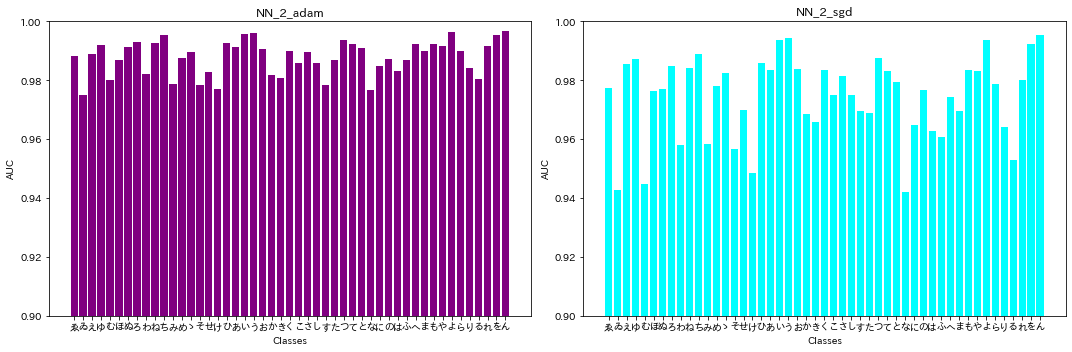

In [70]:
model_1 = nn_trained_models[2]
y_probs_1 = models_predictions[model_1.name]

model_2 = nn_trained_models[3]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

A primeira comparação é entre as duas melhores NNs de cada otimizador. A primeira observação a ser feita, e isso vale para as próximas comparações, é que todos valores de AUC estão acima de 0,90, ou seja, de maneira geral, **não houve um desfavorecimento muito grande no aprendizado de classes com menos amostras**.<br>
É possível perceber que o uso do otimizador Adam favoreceu o aprendizado de certas classes quando comparado com o uso do SGD. Observando a classe ゐ, que possui apenas 400 amostras, o modelo NN_2_adam apresenta uma AUC de ~0,97 enquanto NN_2_sgd chegou a ~0,94; é uma diferença pequena, mas não desprezível, ainda mais considerando que o NN_2_adam apresentou acurácia maior que o NN_2_sgd.

---
### CNN_1_adam vs CNN_2_sgd

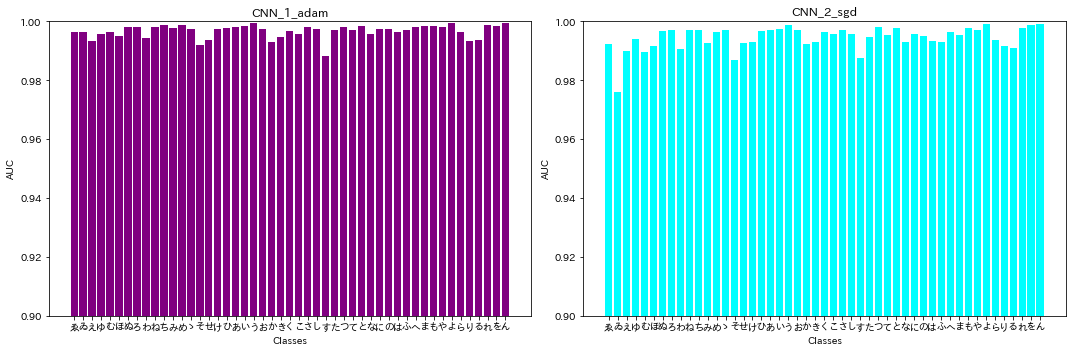

In [73]:
model_1 = cnn_trained_models[0]
y_probs_1 = models_predictions[model_1.name]

model_2 = cnn_trained_models[3]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

Novamente comparando o impacto de usar otimizadores diferentes, mas dessa vez nas CNNs. O primeiro ponto interessante é que, diferentemente das NNs, as CNNs possuem AUCs consistentemente maiores que 0,97. No geral, os valores de AUC são bem similares, mas curiosamente a classe ゐ apresentou uma AUC de ~0,97 com o otimizador SGD, enquanto com o Adam está muito próximo de 1 (o valor máximo). 

---
### NN_dense vs NN_dense_batch_norm

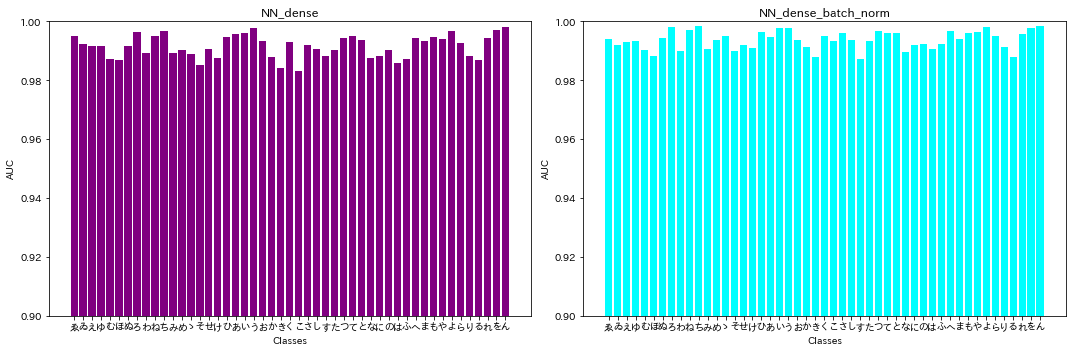

In [75]:
model_1 = nn_trained_models[4]
y_probs_1 = models_predictions[model_1.name]

model_2 = nn_trained_models[5]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

Agora é a vez de comparar as NNs densas, com e sem batch normalization. Os valores de AUC variam entre 0,98 e 1 para ambos os modelos sendo difícil avaliar, por esses plots, qual foi o melhor na média. Essa conclusão só poderá ser tirada na comparação final dos valores médios de AUC de cada modelo (spoiler).

---
### CNN_dense vs CNN_dense_batch_norm

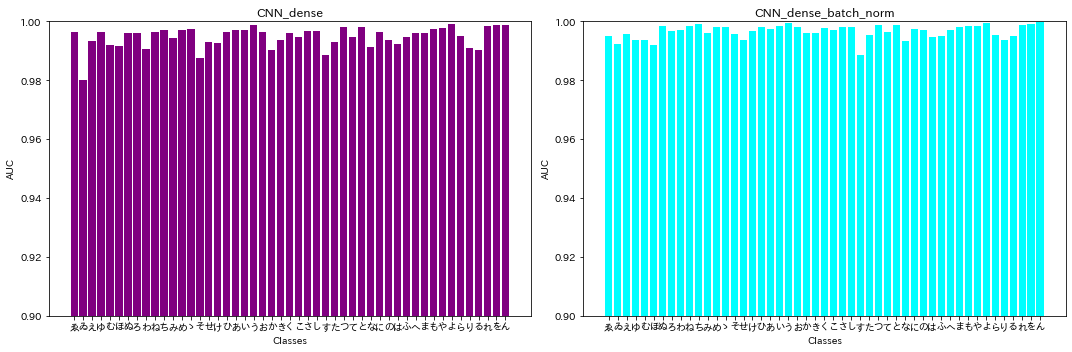

In [76]:
model_1 = cnn_trained_models[4]
y_probs_1 = models_predictions[model_1.name]

model_2 = cnn_trained_models[5]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

Curiosamente, para as CNNs mais densas, é possível notar que o batch normalization ajudou a manter um valor médio de AUC um pouco mais alto. Com o modelo CNN_dense tendo uma AUC um pouco menor para a classe ゐ, ~0,98.

---
### NN_dense_batch_norm vs CNN_dense_batch_norm

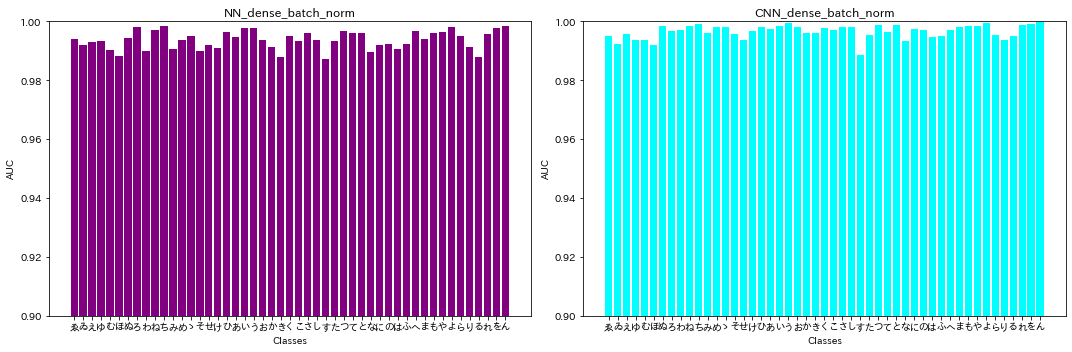

In [74]:
model_1 = nn_trained_models[5]
y_probs_1 = models_predictions[model_1.name]

model_2 = cnn_trained_models[5]
y_probs_2 = models_predictions[model_2.name]

compare_2_models_AUC(model_1, y_probs_1, model_2, y_probs_2)

Por fim comparando ambos NNs e CNNs mais densos com batch normalization, só é possível notar que a CNN manteve um valor de AUC mais alto, em média, quando comparada a NN.<br>
Os resultados finais e conclusivos sobre qual a melhor NN e CNN, e qual o melhor entre os dois, serão apresentados na próxima seção.

### Conclusão Final da Análise AUC Multiclasse
Para sumarizar todos valores de AUC para cada classe e cada modelo, foi usada uma **média ponderada**, onde as classes com menos exemplos possuem maior peso, para que, quanto maior o AUC para uma classe com menos amostras, mais ele contribui para a pontuação final do modelo.<br>

##### PS. 1: a ideia de como os pesos são atribuídos na média ponderada, é que devemos recompensar um modelo que aprende classes com menos exemplos tão bem quanto aprende classes com mais exemplos.

##### PS. 2: os pesos são definidos como o inverso da quantidade de amostras de cada classe.

In [23]:
def get_auc_avg_by_model(models, weights):
    def get_auc_avg(model):
        y_probs = models_predictions[model.name]
        aucs = [get_auc(_class, y_probs) for _class in classes]
        return np.average(aucs, weights=weights)
        
    return [get_auc_avg(model) for model in models]

In [32]:
change_theme('white')

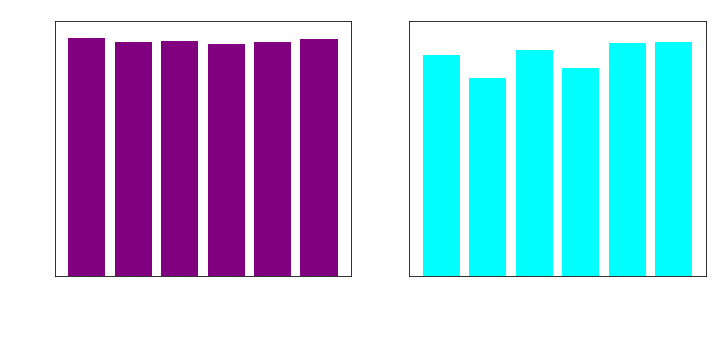

In [33]:
frequencies, classes, hiraganas = get_classes_by_frequency(y_train_original)
weights = [(1/fq) for fq in frequencies]

cnn_auc_avgs = get_auc_avg_by_model(cnn_trained_models, weights)
nn_auc_avgs = get_auc_avg_by_model(nn_trained_models, weights)

cnn_models_names = [trained_model.name for trained_model in cnn_trained_models]
nn_models_names = [trained_model.name for trained_model in nn_trained_models]

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

subplots = [
    {'ax': axes[0], 'xtick_labels': cnn_models_names, 'data': cnn_auc_avgs, 'color': 'purple', 'title': 'Convolutional Neural Networks'},
    {'ax': axes[1], 'xtick_labels': nn_models_names, 'data': nn_auc_avgs, 'color': 'cyan', 'title': 'Neural Networks'},
]

for subplot in subplots:
    ax, xtick_labels, data, color, title = subplot.values()

    hbars = ax.bar(xtick_labels, data, color=color)
    
    ax.set_title(title)
    ax.set_ylim([0.8, 1.01])
    ax.set_xticks(xtick_labels)
    ax.set_xticklabels(labels=xtick_labels, rotation=20, ha='right', rotation_mode='anchor')
    ax.set(xlabel='Models', ylabel='Weighted Average AUC')
    
    ax.bar_label(hbars, labels=[f'{d:.3f}' for d in data])

plt.tight_layout()
plt.savefig('plots/auc_weighted_avg.svg', transparent=True)
plt.show()

Por fim, as observações feitas nas comparações entre as AUCs de cada classe dos modelos, são sumarizadas no plot acima. Observa-se que:
- As CNNs mantém um valor médio de AUC maior que 0,99, maior que da maioria dos valores obtidos pelas NNs;
- O uso do otimizador Adam, pelo menos nas NNs, demonstrou proporcionar um valor de AUC maior e mais consistente;
- Como o valor médio de AUC para todas CNNs é muito próximo, compará-las usando a acurácia é razoável;
- Já para as NNs, é melhor levar ambas métricas em consideração, tanto acurácia quando o valor médio de AUC;

## Conclusão
Para concluir qual o melhor modelo CNN e NN, e qual o melhor entre os dois, é preciso juntas as conclusões tiradas da análise da acurácia e AUC multiclasse. Isso será feito em um último plot **acurácia x média ponderada da AUC**.

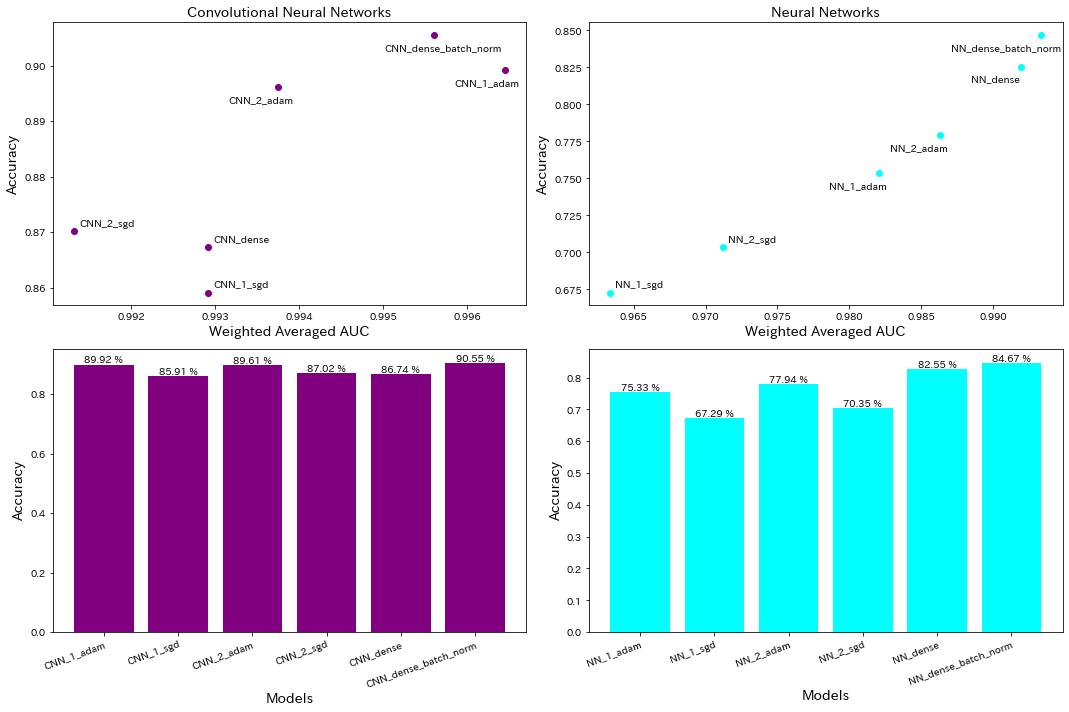

In [31]:
fig, axes = plt.subplots(figsize=(15,10), ncols=2, nrows=2)

cnn_scatter_txt_coords = [(-50,-15), (5,5), (-50,-15), (5,5), (5,5), (-50,-15)]
nn_scatter_txt_coords = [(-50,-15), (5,5), (-50,-15), (5,5), (-50,-15), (-90,-15)]

subplots = [
    {'ax': axes[0,0], 'plot_type': 'scatter', 'xtick_labels': cnn_models_names, 'x': cnn_auc_avgs, 'y': cnn_accuracies, 'color': 'purple', 'title': 'Convolutional Neural Networks', 'scatter_coords': cnn_scatter_txt_coords},
    {'ax': axes[0,1], 'plot_type': 'scatter', 'xtick_labels': nn_models_names, 'x': nn_auc_avgs, 'y': nn_accuracies, 'color': 'cyan', 'title': 'Neural Networks', 'scatter_coords': nn_scatter_txt_coords},
    {'ax': axes[1,0], 'plot_type': 'bar', 'xtick_labels': cnn_models_names, 'x': cnn_models_names, 'y': cnn_accuracies, 'color': 'purple', 'title': '', 'scatter_coords': None},
    {'ax': axes[1,1], 'plot_type': 'bar', 'xtick_labels': nn_models_names, 'x': nn_models_names, 'y': nn_accuracies, 'color': 'cyan', 'title': '', 'scatter_coords': None}
]

for subplot in subplots:
    ax, plot_type, xtick_labels, x, y, color, title, coords = subplot.values()

    if plot_type == 'scatter':
        ax.scatter(x, y, color=color)
        ax.set_ylabel('Accuracy', fontsize=14)
        ax.set_xlabel('Weighted Averaged AUC', fontsize=14)
        
        for i, txt in enumerate(xtick_labels):
            ax.annotate(txt, (x[i], y[i]), xytext=coords[i], textcoords='offset points')
    
    elif plot_type == 'bar':
        hbars = ax.bar(xtick_labels, y, color=color)
        ax.set_xticks(xtick_labels)
        ax.set_xticklabels(labels=xtick_labels, rotation=20, ha='right', rotation_mode='anchor')
        ax.set_xlabel('Models', fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        ax.bar_label(hbars, labels=[f'{100*d:.2f} %' for d in y])
    
    ax.set_title(title, fontsize=14)

plt.tight_layout()
plt.savefig('plots/scatter_accuracy_auc.svg', transparent=True)
plt.show()

Conclusões para as NNs:
- As NNs que usaram o otimizador SGD foram as que obtiveram pior desempenho, com baixa acurácia e menores valores de AUC;
- Em seguida as NNs que utilizaram o otimizador Adam, possuem uma acurácia e AUC um pouco melhores;
- E por fim, as NNs mais densas foram as que obtiveram melhor acurácia e AUC;

Portanto, conclui-se que a **NN_dense_batch_norm foi a melhor NN**.

Obs.: como dito anteriormente, como os valores de AUC para as CNNs são muito similares (todos acima de 0,99) então a escolha do melhor modelo será feita apenas através da acurácia.

Conclusões para as CNNs: 
- Similar as NNs, as CNNs que usaram o otimizador SGD obtiveram menor acurácia;
- Curiosamente a CNN_dense obteve a segunda acurácia mais baixa;
- Enquanto que a CNN_dense_batch_norm obteve a melhor acurácia, seguida da CNN_1_adam e CNN_2_adam;

Como os modelos CNN_dense_batch_norm, CNN_1_adam e CNN_2_adam obtiveram resultados muito semelhantes, para decidir quem foi o melhor, será levado em consideração outro fator: a quantidade de parâmetros treináveis.

In [99]:
[(model.name, count_params(model.trainable_weights))
 for model in conv_neural_networks if model.name in ['CNN_1_adam', 'CNN_2_adam', 'CNN_dense_batch_norm']
]

[('CNN_1_adam', 201073),
 ('CNN_2_adam', 922225),
 ('CNN_dense_batch_norm', 2888719)]

Assim, com apenas **201073 parâmetros treináveis**, ~4,6x menos que a CNN_2_adam possui e ~14,4x menos que a CNN_dense_batch_norm possui, o modelo **CNN_1_adam** foi o que obteve o melhor desempenho entre as CNNs, e também **melhor que a melhor NN** em questões de acurácia e valor de AUC.

## Analisando predições dos melhores modelos

MOSTRAR O QUE OS MELHORES MODELOS (DEFINIDOS NA SEÇÃO ACIMA) ACERTAM E ERRAM
MOSTRAR O QUE ELES FAZEM COM A CLASSE み

### Salvando resultados de todas métricas

In [104]:
if not os.path.exists('results'):
    os.mkdir('results')

with open('results/predictions.npy', 'wb') as f:
    np.save(f, models_predictions)
    
with open('results/cnn_accuracies.npy', 'wb') as f:
    np.save(f, cnn_accuracies)

with open('results/cnn_auc_avgs.npy', 'wb') as f:
    np.save(f, cnn_auc_avgs)
    
with open('results/cnn_losses.npy', 'wb') as f:
    np.save(f, cnn_losses)
    
with open('results/nn_accuracies.npy', 'wb') as f:
    np.save(f, nn_accuracies)

with open('results/nn_auc_avgs.npy', 'wb') as f:
    np.save(f, nn_auc_avgs)
    
with open('results/nn_losses.npy', 'wb') as f:
    np.save(f, nn_losses)

### Referências
- https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
- https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/#:~:text=Specificity%20%E2%80%93%20how%20good%20a%20test,result%20it%27s%20most%20confident%20in.